## 1. 라이브러리 호출

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import pearsonr
from statsmodels.regression.linear_model import OLS
import statsmodels.api as sm
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from factor_analyzer import FactorAnalyzer
import matplotlib.pyplot as plt
from analysis import make_factor_score_df
from analysis import parallel_analysis_scree_plot
from factor_analyzer import calculate_kmo, calculate_bartlett_sphericity
import platform
import pickle
import warnings
warnings.filterwarnings('ignore')

##### 한글 깨짐 방지

In [2]:
# 한글 폰트 설정
if platform.system() == 'Windows':
    plt.rc('font', family='Malgun Gothic')  # '맑은 고딕' (Windows 기본 한글 폰트)
elif platform.system() == 'Darwin':
    plt.rc('font', family='AppleGothic')    # macOS용 한글 폰트
else:
    plt.rc('font', family='NanumGothic')     # 리눅스 등

# 마이너스 깨짐 방지
plt.rcParams['axes.unicode_minus'] = False

## 2. 데이터 불러오기

In [3]:
ts_rtn_df = pd.read_excel('data/ts_rtn_후행.xlsx',dtype={'주식코드' : str}).dropna()

##### 무한대 값이 있는 경우 제거, 상관분석 위해 (회사명, 주식코드, 연도, 수익률 제외)

In [4]:
df_clean = ts_rtn_df.replace([np.inf, -np.inf], np.nan).dropna().iloc[:,3:-1]

## 3. 상관분석
- 자기상관(상관계수가 0.9 이상인 컬럼쌍) 처리
- 대각성분을 제외하고 상관계수의 절댓값이 0.5이하인 값들만 구성되어있는 컬럼 처리

##### 상관관계 분석 후 자기상관 처리

In [5]:
corr_matrix = df_clean.corr().abs()

print("--- 상관 행렬 (절댓값) ---")
print(corr_matrix)
print("-" * 50)

# 중복된 쌍을 제외하고 대각선을 제외한 값들만 추출
# 상관 행렬은 대칭적이므로, 중복된 쌍(예: (A,B)와 (B,A))을 피하고
# 자기 자신과의 상관관계(대각선 값, 항상 1)도 제외합니다.
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# 극도로 높은 상관관계를 가진 변수 쌍 찾기
# 임계값(threshold) 설정: 0.95, 0.99 등 매우 높은 값을 사용합니다.
# 1에 가까울수록 선형 종속성이 강합니다.
threshold = 0.9
highly_correlated_pairs = upper_tri.stack()
highly_correlated_pairs = highly_correlated_pairs[highly_correlated_pairs >= threshold]

print(f"--- 상관 계수 절댓값 {threshold} 이상인 변수 쌍 ---")
if not highly_correlated_pairs.empty:
    print(highly_correlated_pairs.sort_values(ascending=False))
    print("\n이 변수 쌍 중 하나를 제거해야 할 가능성이 높습니다.")

    # 제거할 변수 목록 (예시 로직: 각 쌍에서 두 번째 변수를 제거)
    # 실제로는 도메인 지식을 바탕으로 어떤 변수를 제거할지 결정하는 것이 좋습니다.
    # (예: 정보량이 더 적거나, 이론적으로 덜 중요한 변수)
    cols_to_drop = []
    for (col1, col2), corr_val in highly_correlated_pairs.items():
        if col2 not in cols_to_drop: # 이미 제거 목록에 없는 경우만 추가
            cols_to_drop.append(col2) # 일단 두 번째 변수를 제거 후보로 추가

    # 중복 제거 (필요하다면)
    cols_to_drop = list(set(cols_to_drop))

    if cols_to_drop:
        print(f"\n제거할 변수 후보: {cols_to_drop}")
        x_data_cleaned = df_clean.drop(columns=cols_to_drop)
        print("\n--- 상관관계 높은 변수 제거 후 x_data의 shape ---")
        print(x_data_cleaned.shape)
        print(f"남은 컬럼: {x_data_cleaned.columns.tolist()}")
    else:
        x_data_cleaned = df_clean.copy() # 제거할 컬럼이 없으면 원본 유지
        print("제거할 변수 후보가 없습니다.")

else:
    print("설정한 임계값 이상의 극도로 높은 상관관계를 가진 변수 쌍이 없습니다.")
    x_data_cleaned = df_clean.copy() # 제거할 컬럼이 없으면 원본 유지

--- 상관 행렬 (절댓값) ---
                총자본증가율(IFRS)  유형자산증가율(IFRS)  투자부동산증가율(IFRS)  비유동자산증가율(IFRS)  \
총자본증가율(IFRS)        1.000000       0.002604        0.023701        0.754267   
유형자산증가율(IFRS)       0.002604       1.000000        0.000468        0.000192   
투자부동산증가율(IFRS)      0.023701       0.000468        1.000000        0.044661   
비유동자산증가율(IFRS)      0.754267       0.000192        0.044661        1.000000   
유동자산증가율(IFRS)       0.401045       0.005739        0.003247        0.074401   
...                      ...            ...             ...             ...   
기계투자효율(IFRS)        0.005643       0.000931        0.001611        0.049013   
부가가치율(IFRS)         0.080583       0.013580        0.002611        0.128052   
노동소득분배율(IFRS)       0.016690       0.001529        0.003275        0.006464   
자본분배율(IFRS)         0.015045       0.002356        0.000046        0.008093   
이윤분배율(IFRS)         0.049071       0.000080        0.000603        0.030496   

                유동자산증가율(IFRS)  

##### 상관행렬 계산 및 시각화

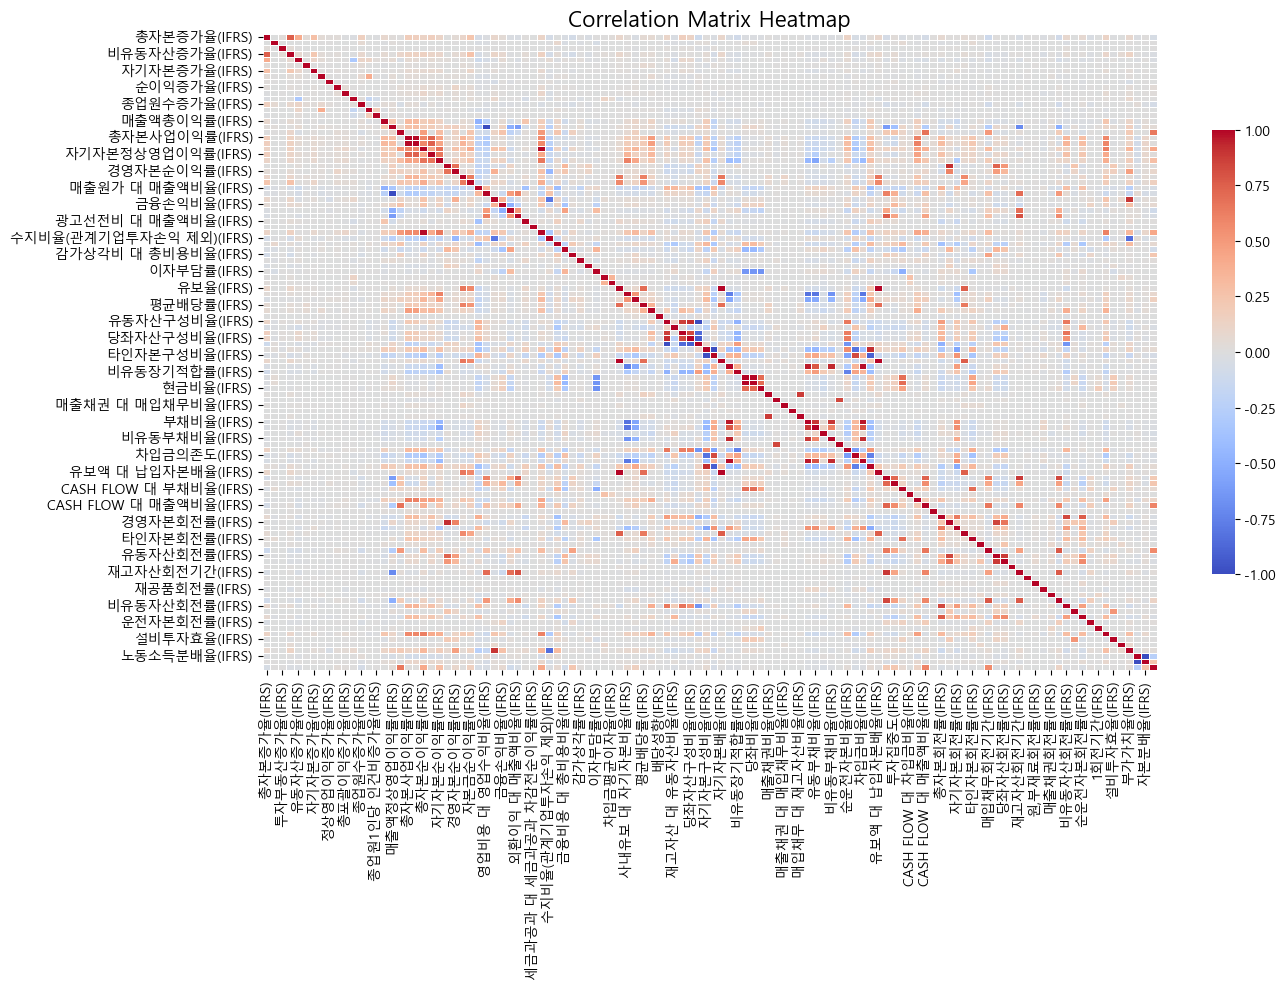

In [6]:
# 상관 행렬 계산
corr_matrix = df_clean.corr()

# 히트맵 출력
plt.figure(figsize=(14, 10))
sns.heatmap(corr_matrix, 
            annot=False,       # True로 하면 숫자도 표시
            cmap='coolwarm',   # 색상 맵
            vmin=-1, vmax=1,   # 상관계수 범위 고정
            center=0,          # 0을 중심으로
            linewidths=0.5,    # 셀 경계선
            cbar_kws={'shrink': 0.7})  # 컬러바 크기 축소

plt.title("Correlation Matrix Heatmap", fontsize=16)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


##### 대각성분을 제외

In [7]:
# 상관관계가 0.5보다 낮은 값들만 구성된 컬럼은 제거
corr = x_data_cleaned.corr()

# 각 컬럼별로, 자기 자신을 제외한 나머지 컬럼들과의 상관계수 절대값이 모두 0.5 미만인지 확인
cols_to_drop = []

# 해당 컬럼 삭제
filtered_data = x_data_cleaned.drop(columns=cols_to_drop)
filtered_data

,총자본증가율(IFRS),유형자산증가율(IFRS),투자부동산증가율(IFRS),비유동자산증가율(IFRS),유동자산증가율(IFRS),재고자산증가율(IFRS),자기자본증가율(IFRS),매출액증가율(IFRS),정상영업이익증가율(IFRS),순이익증가율(IFRS),...,유형자산회전율(IFRS),순운전자본회전률(IFRS),운전자본회전률(IFRS),1회전기간(IFRS),총자본투자효율(IFRS),설비투자효율(IFRS),기계투자효율(IFRS),부가가치율(IFRS),노동소득분배율(IFRS),이윤분배율(IFRS)
0,11.35,33.72,0.0,29.12,2.65,48.02,11.27,17.74,136.71,166.52,...,2.81,1.07,0.0,0.01,13.28,55.27,943.98,16.71,0.00,73.46
1,41.31,136.95,0.0,118.90,-6.52,57.76,14.64,7.70,19.14,32.67,...,1.57,1.00,0.0,0.01,12.25,69.07,1204.12,20.23,0.00,74.74
2,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,1.37,0.88,0.0,0.01,23.73,53.18,215.32,36.74,66.47,13.91
3,1.83,19.91,0.0,17.06,-15.41,-13.37,5.74,8.96,51.84,60.66,...,1.36,1.01,0.0,0.01,24.74,44.60,254.08,35.80,61.21,21.05
4,-4.46,-2.34,0.0,-1.96,-8.38,-1.77,-1.15,-4.77,-60.96,-92.58,...,1.20,1.05,0.0,0.01,23.01,41.15,239.59,33.41,72.78,1.76
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4601,3.70,5.58,0.0,2.95,4.60,-5.49,-4.44,-5.96,17.91,-6.58,...,14.36,5.30,0.0,0.03,35.78,137.05,50080.69,9.68,42.21,14.31
4602,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,23.84,1.74,0.0,0.01,46.89,920.61,0.00,38.57,7.43,61.88
4603,32.54,82.49,0.0,34.26,29.85,9.24,38.51,4.83,0.65,7.70,...,17.69,1.74,0.0,0.01,36.91,907.64,0.00,38.39,8.78,63.87
4604,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,23.00,2.19,0.0,0.00,6.34,2127.64,80447.21,80.42,9.21,91.10


## 4. 요인분석

##### 요인 분석에 대한 적합성 검정
- KMO 검정
- 바틀렛 검정

##### KMO 검정

In [8]:
kmo_all, kmo_model = calculate_kmo(filtered_data)
print(f"KMO 전체 통계량: {kmo_model:.4f}")
if kmo_model >= 0.6:
    print("→ 요인 분석에 적합한 데이터입니다 (KMO ≥ 0.6)")
else:
    print("→ 요인 분석에 부적합할 수 있습니다 (KMO < 0.6)")

KMO 전체 통계량: 0.6608
→ 요인 분석에 적합한 데이터입니다 (KMO ≥ 0.6)


##### Bartlett's Test

In [9]:
chi_square_value, p_value = calculate_bartlett_sphericity(filtered_data)
print(f"Bartlett's Test Chi-square: {chi_square_value:.2f}, p-value: {p_value:.4f}")
if p_value < 0.05:
    print("→ 변수 간 상관관계가 존재하므로 요인분석 적합")
else:
    print("→ 상관관계가 부족하여 요인분석에 적합하지 않을 수 있음")

Bartlett's Test Chi-square: 308382.99, p-value: 0.0000
→ 변수 간 상관관계가 존재하므로 요인분석 적합


##### 최적의 팩터 개수 찾기
- analysis.py에서 parallel_analysis_scree_plot 함수 이용

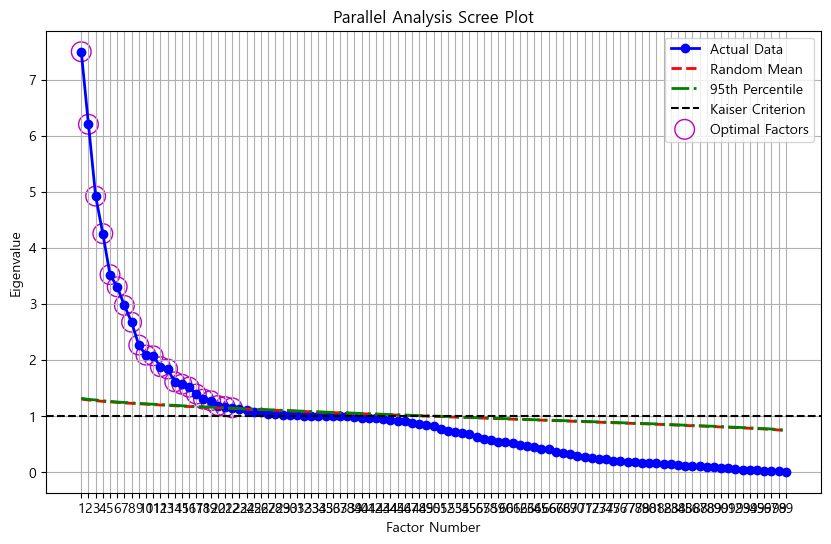

Suggested number of factors: 22


,factor_1,factor_2,factor_3,factor_4,factor_5,factor_6,factor_7,factor_8,factor_9,factor_10,...,factor_13,factor_14,factor_15,factor_16,factor_17,factor_18,factor_19,factor_20,factor_21,factor_22
0,0.677612,-0.000901,-0.176526,-0.064991,-0.088567,-0.430851,0.087975,0.017430,0.150269,1.310394,...,-0.067228,-0.290755,-0.140528,-0.148301,0.017969,-0.084379,1.735071,-0.607187,-0.773076,-0.726298
1,0.708037,-0.002788,0.071997,-0.403439,-0.072283,-0.486074,-0.165542,0.047393,-0.006080,-0.164758,...,0.005336,-0.284699,-0.321597,-0.136002,-0.058307,0.063369,1.296963,-0.394403,-0.634709,-0.638498
2,0.075879,-0.009078,-0.450493,-0.430046,0.230592,-0.407688,-0.278706,-0.099379,0.103339,0.291727,...,-0.063981,-0.135841,-0.185071,-0.150360,0.102670,0.255914,0.975600,0.019123,-0.174793,-0.499375
3,0.490263,-0.016963,-0.223484,-0.472393,0.100280,-0.444361,-0.310388,-0.098914,-0.105695,-0.260586,...,-0.033780,-0.894062,-0.230483,-0.093173,0.048095,0.241809,0.757774,0.205195,-0.038012,-0.457578
4,0.124064,-0.002820,-0.049799,-0.499604,0.111734,-0.418089,-0.299912,-0.115562,-0.094258,-0.276654,...,-0.042156,-0.954266,-0.219280,-0.112352,0.076000,0.229047,1.159315,0.174766,-0.011091,-0.377718
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4601,-0.603667,0.249960,8.900732,0.804328,0.063029,-0.269329,-0.452385,0.733940,0.564636,0.080612,...,-0.321376,-0.127719,-0.435479,-1.224849,-1.332044,1.524311,3.566955,13.166162,0.019147,5.254600
4602,3.650571,0.055230,-0.055616,0.258469,-0.325610,8.656456,0.149735,-0.142103,-0.355692,-0.042516,...,0.058100,1.439378,-0.391779,-0.305407,-0.116034,0.020185,1.193356,-0.918398,-0.790391,-0.903935
4603,2.840653,0.043260,-0.166121,0.171706,-0.448224,9.265531,0.030494,-0.132197,-0.482319,-0.112583,...,0.082483,0.443710,-0.428323,-0.269200,-0.178090,0.092909,0.776536,-0.430958,-0.508853,-0.835968
4604,-0.177109,-0.697414,-1.790086,0.018704,1.577768,2.364122,1.517503,0.632229,-0.472343,-1.991224,...,-0.034090,-2.545673,-0.234573,-0.250054,2.726901,0.843389,0.876222,0.486062,2.312433,2.545355


In [10]:
optim = parallel_analysis_scree_plot(filtered_data, n_iter=100, random_state=42)

X_data = make_factor_score_df(optim,filtered_data)
X_data

## 5. RLM

##### VIF 계산 위해 상수항 추가

In [11]:
y = ts_rtn_df.iloc[:,-1]
X_data = sm.add_constant(X_data)

# X_data, y = X_data.align(y, join='inner', axis=0)
y.index = X_data.index
model = sm.RLM(y,X_data)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                    Robust linear Model Regression Results                    
==============================================================================
Dep. Variable:                    수익률   No. Observations:                 4606
Model:                            RLM   Df Residuals:                     4583
Method:                          IRLS   Df Model:                           22
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Fri, 30 May 2025                                         
Time:                        09:24:25                                         
No. Iterations:                    30                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0019      0.005     -0.374      0.709      -0.012       0.008
factor_1       0.0069      0.005      1.323      0.186      -0.003       0.017
factor_2      -0.0076      0.005     -1.463      0.143      -0.018       0.003
factor_3       0.0086      0.005      1.661      0.097      -0.002       0.019
factor_4      -0.0019      0.005     -0.375      0.708      -0.012       0.008
factor_5       0.0015      0.005      0.294      0.769      -0.009       0.012
factor_6      -0.0041      0.005     -0.796      0.426      -0.014       0.006
factor_7       0.0050      0.005      0.959      0.338      -0.005       0.015
factor_8      -0.0048      0.005     -0.935      0.350      -0.015       0.005
factor_9       0.0025      0.005      0.475      0.635      -0.008       0.013
factor_10     -0.0003      0.005     -0.063      0.950      -0.010       0.010
factor_11     -0.0119      0.005     -2.285      0.022      -0.022      -0.002
factor_12     -0.0003      0.005     -0.064      0.949      -0.010       0.010
factor_13     -0.0037      0.005     -0.714      0.475      -0.014       0.006
factor_14     -0.0084      0.005     -1.622      0.105      -0.019       0.002
factor_15      0.0007      0.005      0.136      0.892      -0.009       0.011
factor_16      0.0039      0.005      0.759      0.448      -0.006       0.014
factor_17      0.0007      0.005      0.139      0.890      -0.009       0.011
factor_18     -0.0011      0.005     -0.218      0.828      -0.011       0.009
factor_19     -0.0002      0.005     -0.040      0.968      -0.010       0.010
factor_20     -0.0070      0.005     -1.344      0.179      -0.017       0.003
factor_21     -0.0055      0.005     -1.064      0.287      -0.016       0.005
factor_22      0.0020      0.005      0.385      0.700      -0.008       0.012
==============================================================================

If the model instance has been used for another fit with different fit parameters, then the fit options might not be the correct ones anymore .
"""

##### 요인분석 - method : principal
- stnadardscaler 사용

In [12]:
fa = FactorAnalyzer(n_factors=optim,rotation='varimax',method='principal')
scaler = StandardScaler()
scaled_data = scaler.fit_transform(filtered_data)
fa_fit = fa.fit(scaled_data)

##### 요인 점수 추출 및 특정 요인 선택
- 요인분석 결과로부터 추출한 요인 부하량(loadings)을 기반으로 요인 점수 데이터프레임을 생성
- 전체 요인 중에서 관심 있는 요인(factor_6, factor_10, factor_11, factor_13, factor_14)만 선택하여 후속 분석에 활용

In [13]:
factor_df = pd.DataFrame(fa_fit.loadings_,columns=[f"factor_{i+1}" for i in range(optim)],index=filtered_data.columns)
factor_list = ['factor_11']
factor_df = factor_df[factor_list]

##### 요인 부하량 결과 시각화 및 저장

In [14]:
with pd.ExcelWriter('data/valid_factor_loadings_fix_후행.xlsx', engine='xlsxwriter') as writer:
    (factor_df.style
     .background_gradient(cmap='coolwarm', axis=1, vmin=-1, vmax=1)
     .to_excel(writer, sheet_name='Factor Loadings'))

##### BackTesting.ipynb에 이용할 적재 행렬과 요인 점수 데이터 보내기 위해 객체에 저장

In [15]:
factor_df = factor_df[factor_list]
# 적재 행렬과 요인 점수 데이터 보내기
X_data.to_excel('data/factor_score_후행.xlsx')
factor_df.to_excel('data/factor_loadings_후행.xlsx')

# 회귀계수 데이터, fa 객체 저장
factor_coefficients_for_backtest = results.params[factor_list]

with open("data/coef.pickle",'wb') as f:
    pickle.dump(factor_coefficients_for_backtest,f)
    pickle.dump(fa,f)